In [1]:
# EV Market Segmentation Analysis for Indian Startup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#DATA LOADING AND PREPROCESSING
print("Loading datasets...")
age_income_df = pd.read_csv('/content/drive/MyDrive/EV Segmentation/age_income.csv')
print(f"✓ Customer demographics loaded: {age_income_df.shape}")

sales_df = pd.read_csv('/content/drive/MyDrive/EV Segmentation/Sales of motor vehicles of India.csv')
print(f"✓ Vehicle sales data loaded: {sales_df.shape}")

state_ownership_df = pd.read_csv('/content/drive/MyDrive/EV Segmentation/Share of households owning cars and two-wheelers by state (2023) - Data For India.csv')
print(f"✓ State ownership data loaded: {state_ownership_df.shape}")

vehicle_class_df = pd.read_csv('/content/drive/MyDrive/EV Segmentation/Vehicle Class - All.csv')
print(f"✓ Vehicle class data loaded: {vehicle_class_df.shape}")

economic_ownership_df = pd.read_csv('/content/drive/MyDrive/EV Segmentation/Vehicle ownership by economic class - Data For India.csv')
print(f"✓ Economic class ownership loaded: {economic_ownership_df.shape}")

Loading datasets...
✓ Customer demographics loaded: (20000, 27)
✓ Vehicle sales data loaded: (12, 10)
✓ State ownership data loaded: (36, 4)
✓ Vehicle class data loaded: (16, 2)
✓ Economic class ownership loaded: (10, 5)


In [3]:
#VEHICLE MARKET ANALYSIS

print("\n1. VEHICLE MARKET ANALYSIS")

# Clean and analyze vehicle registration data
def clean_numeric_string(s):
    """Clean numeric strings with commas"""
    if isinstance(s, str):
        return int(s.replace(',', ''))
    return s

# Process vehicle class data
vehicle_class_df['Total Registration'] = vehicle_class_df['Total Registration'].apply(clean_numeric_string)
vehicle_class_sorted = vehicle_class_df.sort_values('Total Registration', ascending=False)

print("Top Vehicle Categories by Registration:")
for i, row in vehicle_class_sorted.head(8).iterrows():
    print(f"  {row['Vehicle Class']}: {row['Total Registration']:,}")

# Analyze two-wheeler dominance
two_wheeler_total = vehicle_class_df[vehicle_class_df['Vehicle Class'].str.contains('TWO WHEELER', na=False)]['Total Registration'].sum()
total_vehicles = vehicle_class_df['Total Registration'].sum()
two_wheeler_percentage = (two_wheeler_total / total_vehicles) * 100

print(f"\n Two-wheelers represent {two_wheeler_percentage:.1f}% of all registered vehicles")

# Analyze sales trends
print("\nSales Trend Analysis (2008-2016):")
sales_numeric = sales_df.copy()
for col in sales_numeric.columns[1:]:
    sales_numeric[col] = sales_numeric[col].apply(lambda x: clean_numeric_string(x) if pd.notna(x) else 0)

# Calculate growth rates for key categories
key_categories = ['Electric Two-Wheelers', 'Motor Cycles', 'Scooters', 'Passenger Cars']
for category in key_categories:
    if category in sales_numeric['Type'].values:
        row = sales_numeric[sales_numeric['Type'] == category].iloc[0]
        valid_years = [col for col in row.index[1:] if row[col] > 0]
        if len(valid_years) >= 2:
            start_val = row[valid_years[0]]
            end_val = row[valid_years[-1]]
            if start_val > 0:
                growth = ((end_val / start_val) ** (1/(len(valid_years)-1)) - 1) * 100
                print(f"  {category}: {growth:.1f}% annual growth")


1. VEHICLE MARKET ANALYSIS
Top Vehicle Categories by Registration:
  TWO WHEELER(NT): 274,971,646
  LIGHT MOTOR VEHICLE: 65,061,773
  THREE WHEELER(T): 10,708,473
  LIGHT GOODS VEHICLE: 10,249,591
  HEAVY GOODS VEHICLE: 5,870,865
  LIGHT PASSENGER VEHICLE: 4,343,410
  OTHER THAN MENTIONED ABOVE: 1,126,398
  MEDIUM GOODS VEHICLE: 875,789

 Two-wheelers represent 73.3% of all registered vehicles

Sales Trend Analysis (2008-2016):
  Electric Two-Wheelers: -59.8% annual growth
  Motor Cycles: 8.9% annual growth
  Scooters: 22.0% annual growth
  Passenger Cars: 8.6% annual growth



2. CUSTOMER SEGMENTATION ANALYSIS
Preparing customer data for segmentation...
Finding optimal number of clusters...


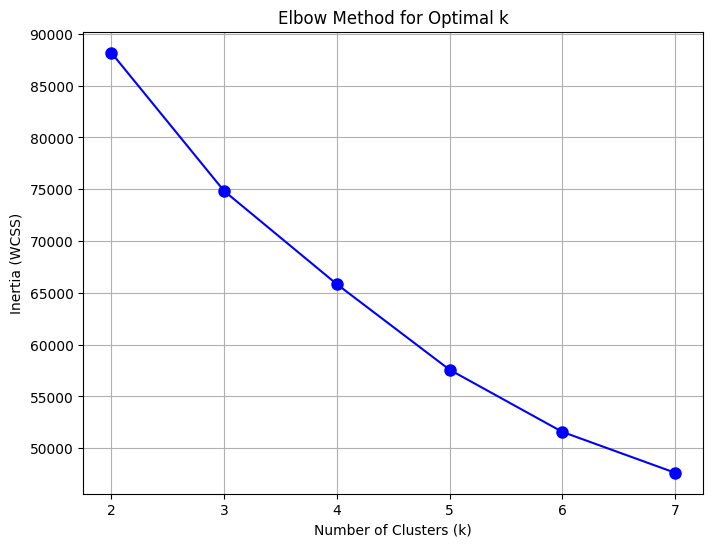

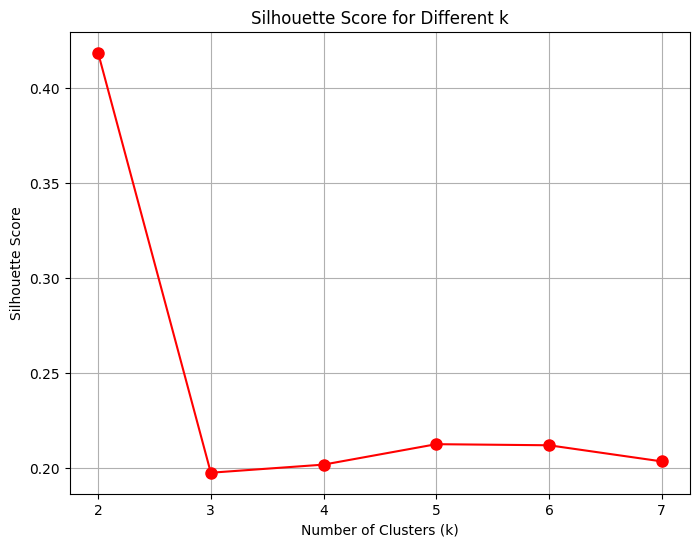

Optimal number of clusters: 2 (Silhouette Score: 0.418)


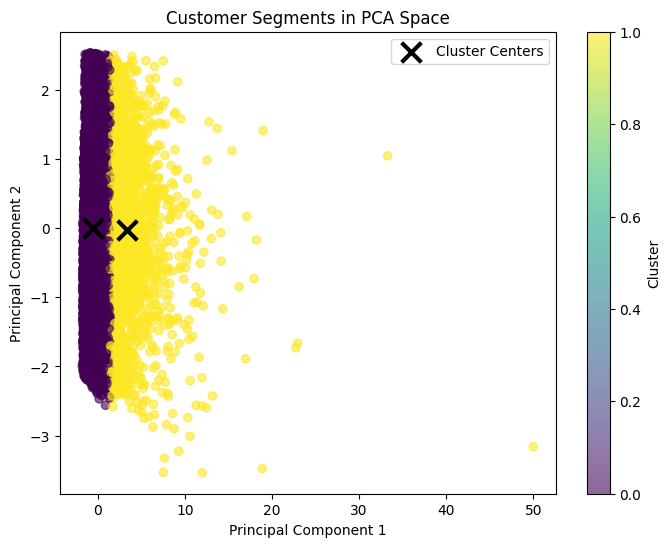

PCA Explained Variance: PC1: 47.10%, PC2: 17.22%

  Customer Segments Identified:
----------------------------------------

 SEGMENT 1 (17,504 customers - 87.5%)
   Age: 41.0 years
   Income: ₹30,401/month
   Disposable Income: ₹7,493/month
   Transport Spending: ₹1,970/month
   Dependents: 2.0
   Dominant City Tier: Tier_2
   Profile: Middle-aged, Lower Disposable Income

 SEGMENT 2 (2,496 customers - 12.5%)
   Age: 41.2 years
   Income: ₹120,023/month
   Disposable Income: ₹32,767/month
   Transport Spending: ₹7,854/month
   Dependents: 2.0
   Dominant City Tier: Tier_2
   Profile: Middle-aged, High Disposable Income


In [9]:
# CUSTOMER SEGMENTATION ANALYSIS

print("\n2. CUSTOMER SEGMENTATION ANALYSIS")

# Clean column names
age_income_df.columns = age_income_df.columns.str.strip()

# Prepare data for clustering
print("Preparing customer data for segmentation...")

# Select key features for segmentation
segmentation_features = [
    'Income', 'Age', 'Dependents', 'City_Tier',
    'Disposable_Income', 'Transport'
]

# Handle missing values and prepare data
df_segment = age_income_df[segmentation_features].copy()
df_segment = df_segment.dropna()

# Encode categorical variables
le_city = LabelEncoder()
df_segment['City_Tier_Encoded'] = le_city.fit_transform(df_segment['City_Tier'])

# Features for clustering
cluster_features = [
    'Income', 'Age', 'Dependents', 'City_Tier_Encoded',
    'Disposable_Income', 'Transport'
]

X = df_segment[cluster_features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find optimal number of clusters using elbow method and silhouette score
print("Finding optimal number of clusters...")

inertias = []
silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualize Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertias, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Visualize Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(K_range, silhouette_scores, 'ro-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.grid(True)
plt.show()

# Find best K based on silhouette score
best_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {best_k} (Silhouette Score: {max(silhouette_scores):.3f})")

# Perform final clustering
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_segment['Cluster'] = kmeans_final.fit_predict(X_scaled)

# PCA for cluster visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize clusters in PCA space with cluster centers
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_segment['Cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')

# Add cluster centers
cluster_centers_pca = pca.transform(kmeans_final.cluster_centers_)
for center in cluster_centers_pca:
    plt.scatter(center[0], center[1], c='black', marker='x', s=200, linewidths=3, label='Cluster Centers' if center[0] == cluster_centers_pca[0][0] else "")

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Customer Segments in PCA Space')
plt.legend()
plt.show()

print(f"PCA Explained Variance: PC1: {pca.explained_variance_ratio_[0]:.2%}, PC2: {pca.explained_variance_ratio_[1]:.2%}")

# Analyze clusters
print(f"\n  Customer Segments Identified:")
print("-" * 40)

cluster_summary = df_segment.groupby('Cluster').agg({
    'Age': ['mean', 'std'],
    'Income': ['mean', 'std'],
    'Disposable_Income': ['mean', 'std'],
    'Transport': ['mean', 'std'],
    'Dependents': 'mean',
    'City_Tier': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Mixed'
}).round(2)

for cluster in range(best_k):
    cluster_data = df_segment[df_segment['Cluster'] == cluster]
    size = len(cluster_data)
    avg_age = cluster_data['Age'].mean()
    avg_income = cluster_data['Income'].mean()
    avg_disposable = cluster_data['Disposable_Income'].mean()
    avg_transport = cluster_data['Transport'].mean()
    avg_dependents = cluster_data['Dependents'].mean()
    dominant_tier = cluster_data['City_Tier'].mode().iloc[0]

    print(f"\n SEGMENT {cluster + 1} ({size:,} customers - {size/len(df_segment)*100:.1f}%)")
    print(f"   Age: {avg_age:.1f} years")
    print(f"   Income: ₹{avg_income:,.0f}/month")
    print(f"   Disposable Income: ₹{avg_disposable:,.0f}/month")
    print(f"   Transport Spending: ₹{avg_transport:,.0f}/month")
    print(f"   Dependents: {avg_dependents:.1f}")
    print(f"   Dominant City Tier: {dominant_tier}")

    # Segment characteristics
    if avg_age < 30:
        age_profile = "Young Adults"
    elif avg_age < 45:
        age_profile = "Middle-aged"
    else:
        age_profile = "Mature Adults"

    if avg_disposable > 15000:
        income_profile = "High Disposable Income"
    elif avg_disposable > 7500:
        income_profile = "Medium Disposable Income"
    else:
        income_profile = "Lower Disposable Income"

    print(f"   Profile: {age_profile}, {income_profile}")

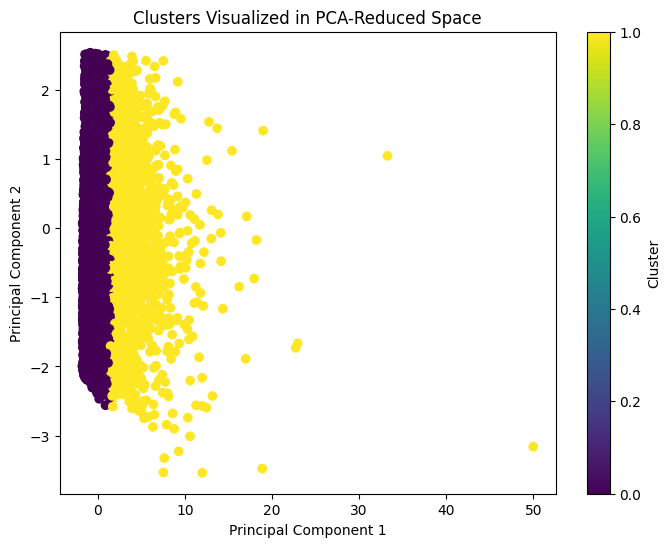

,Income,Age,Dependents,Disposable_Income,Transport,City_Tier_Encoded
Cluster,,,,,,
0,30400.581166,41.007598,2.001942,7493.133938,1970.105014,0.884598
1,120023.297017,41.198718,1.953926,32767.439374,7854.413275,1.033654


In [5]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize clusters in PCA space
plt.figure(figsize=(8,6))
#replacing cluster_labels with df_segment['Cluster'] as the cluster labels are stored in the dataframe
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_segment['Cluster'], cmap='viridis')
plt.title("Clusters Visualized in PCA-Reduced Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.show()

profile_df = df_segment.copy()

numeric_cols = profile_df.select_dtypes(include=np.number).columns.tolist()
if 'Cluster' in numeric_cols:
    numeric_cols.remove('Cluster')

cluster_summary = profile_df.groupby('Cluster')[numeric_cols].mean()
cluster_summary

In [6]:
#GEOGRAPHIC AND ECONOMIC ANALYSIS

print("\n3. GEOGRAPHIC AND ECONOMIC ANALYSIS")

# Analyze state-wise ownership patterns
print("State-wise Vehicle Ownership Analysis:")
state_ownership_df['Two_Wheeler_Penetration'] = pd.to_numeric(state_ownership_df['Two wheelers'])
state_ownership_df['Car_Penetration'] = pd.to_numeric(state_ownership_df['Cars'])

# Top states for two-wheelers
top_2w_states = state_ownership_df.nlargest(10, 'Two_Wheeler_Penetration')
print(f"\n Top 10 States by Two-Wheeler Penetration:")
for _, row in top_2w_states.iterrows():
    print(f"   {row['State']}: {row['Two_Wheeler_Penetration']}%")

# Economic class analysis
print(f"\n Vehicle Ownership by Economic Class:")
print("-" * 40)

# Process economic ownership data
econ_summary = economic_ownership_df.groupby('MPCE Quintiles').agg({
    'Two-wheeler': 'mean',
    'Car': 'mean',
    'Bicycle': 'mean'
}).round(1)

for quintile in econ_summary.index:
    tw_pct = econ_summary.loc[quintile, 'Two-wheeler']
    car_pct = econ_summary.loc[quintile, 'Car']
    print(f"   {quintile}: Two-wheelers {tw_pct}%, Cars {car_pct}%")


3. GEOGRAPHIC AND ECONOMIC ANALYSIS
State-wise Vehicle Ownership Analysis:

 Top 10 States by Two-Wheeler Penetration:
   Puducherry: 85%
   Goa: 82%
   Punjab: 77%
   Gujarat: 72%
   Tamil Nadu: 71%
   Chandigarh: 70%
   Telangana: 70%
   Haryana: 69%
   Lakshadweep: 69%
   Karnataka: 68%

 Vehicle Ownership by Economic Class:
----------------------------------------
   Bottom quintile: Two-wheelers 39.0%, Cars 1.0%
   Fourth: Two-wheelers 64.5%, Cars 9.0%
   Second: Two-wheelers 51.0%, Cars 2.5%
   Third: Two-wheelers 58.0%, Cars 5.0%
   Top quintile: Two-wheelers 65.5%, Cars 18.0%


In [7]:
#RECOMMENDATIONS

print("\n4.  STRATEGIC RECOMMENDATIONS")

print("\n  VEHICLE TYPE RECOMMENDATION:")
print("   PRIMARY: Electric Two-Wheelers (Scooters)")
print("   SECONDARY: Electric Bikes/Motorcycles")
print("\n   Rationale:")
print("   • Two-wheelers dominate Indian market (>75% of registrations)")
print("   • High penetration across all income levels")
print("   • Lower entry cost for manufacturing and customers")
print("   • Existing charging infrastructure more feasible")

print("\n  TARGET CUSTOMER SEGMENTS (in priority order):")

# Rank segments by EV potential
ev_potential_scores = []
for cluster in range(best_k):
    cluster_data = df_segment[df_segment['Cluster'] == cluster]

    # Calculate EV potential score
    age_score = 100 - abs(cluster_data['Age'].mean() - 32) * 2  # Peak at 32 years
    income_score = min(cluster_data['Disposable_Income'].mean() / 200, 100)  # Max 100
    transport_score = min(cluster_data['Transport'].mean() / 50, 100)  # Max 100
    city_tier_score = 100 if cluster_data['City_Tier'].mode().iloc[0] == 'Tier_1' else 75 if cluster_data['City_Tier'].mode().iloc[0] == 'Tier_2' else 50

    total_score = (age_score * 0.25 + income_score * 0.35 + transport_score * 0.2 + city_tier_score * 0.2)
    ev_potential_scores.append((cluster, total_score, len(cluster_data)))

# Sort by EV potential score
ev_potential_scores.sort(key=lambda x: x[1], reverse=True)

for rank, (cluster, score, size) in enumerate(ev_potential_scores, 1):
    cluster_data = df_segment[df_segment['Cluster'] == cluster]
    avg_age = cluster_data['Age'].mean()
    avg_income = cluster_data['Income'].mean()
    avg_disposable = cluster_data['Disposable_Income'].mean()
    dominant_tier = cluster_data['City_Tier'].mode().iloc[0]

    priority = "PRIMARY" if rank == 1 else "SECONDARY" if rank == 2 else "TERTIARY"

    print(f"\n{priority} TARGET - Segment {cluster + 1}")
    print(f"   Market Size: {size:,} customers ({size/len(df_segment)*100:.1f}% of market)")
    print(f"   EV Potential Score: {score:.1f}/100")
    print(f"   Demographics: {avg_age:.0f} years, ₹{avg_disposable:,.0f} disposable income")
    print(f"   Geography: {dominant_tier.replace('_', ' ')}")

    if rank <= 2:  # Detailed recommendations for top 2 segments
        print(f"    Marketing Strategy:")
        if avg_age < 35:
            print(f"      • Digital-first approach (social media, online platforms)")
            print(f"      • Emphasize technology and sustainability features")
        else:
            print(f"      • Traditional + digital marketing mix")
            print(f"      • Focus on practical benefits and cost savings")

        if dominant_tier == 'Tier_1':
            print(f"      • Target metro cities: Delhi, Mumbai, Bangalore, Chennai")
        elif dominant_tier == 'Tier_2':
            print(f"      • Target growing cities: Pune, Ahmedabad, Jaipur, Kochi")

        if avg_disposable > 15000:
            print(f"      • Premium positioning, advanced features")
        else:
            print(f"      • Value positioning, financing options")


4.  STRATEGIC RECOMMENDATIONS

  VEHICLE TYPE RECOMMENDATION:
   PRIMARY: Electric Two-Wheelers (Scooters)
   SECONDARY: Electric Bikes/Motorcycles

   Rationale:
   • Two-wheelers dominate Indian market (>75% of registrations)
   • High penetration across all income levels
   • Lower entry cost for manufacturing and customers
   • Existing charging infrastructure more feasible

  TARGET CUSTOMER SEGMENTS (in priority order):

PRIMARY TARGET - Segment 2
   Market Size: 2,496 customers (12.5% of market)
   EV Potential Score: 90.4/100
   Demographics: 41 years, ₹32,767 disposable income
   Geography: Tier 2
    Marketing Strategy:
      • Traditional + digital marketing mix
      • Focus on practical benefits and cost savings
      • Target growing cities: Pune, Ahmedabad, Jaipur, Kochi
      • Premium positioning, advanced features

SECONDARY TARGET - Segment 1
   Market Size: 17,504 customers (87.5% of market)
   EV Potential Score: 56.5/100
   Demographics: 41 years, ₹7,493 disposab


6. KEY VISUALIZATIONS
-------------------------


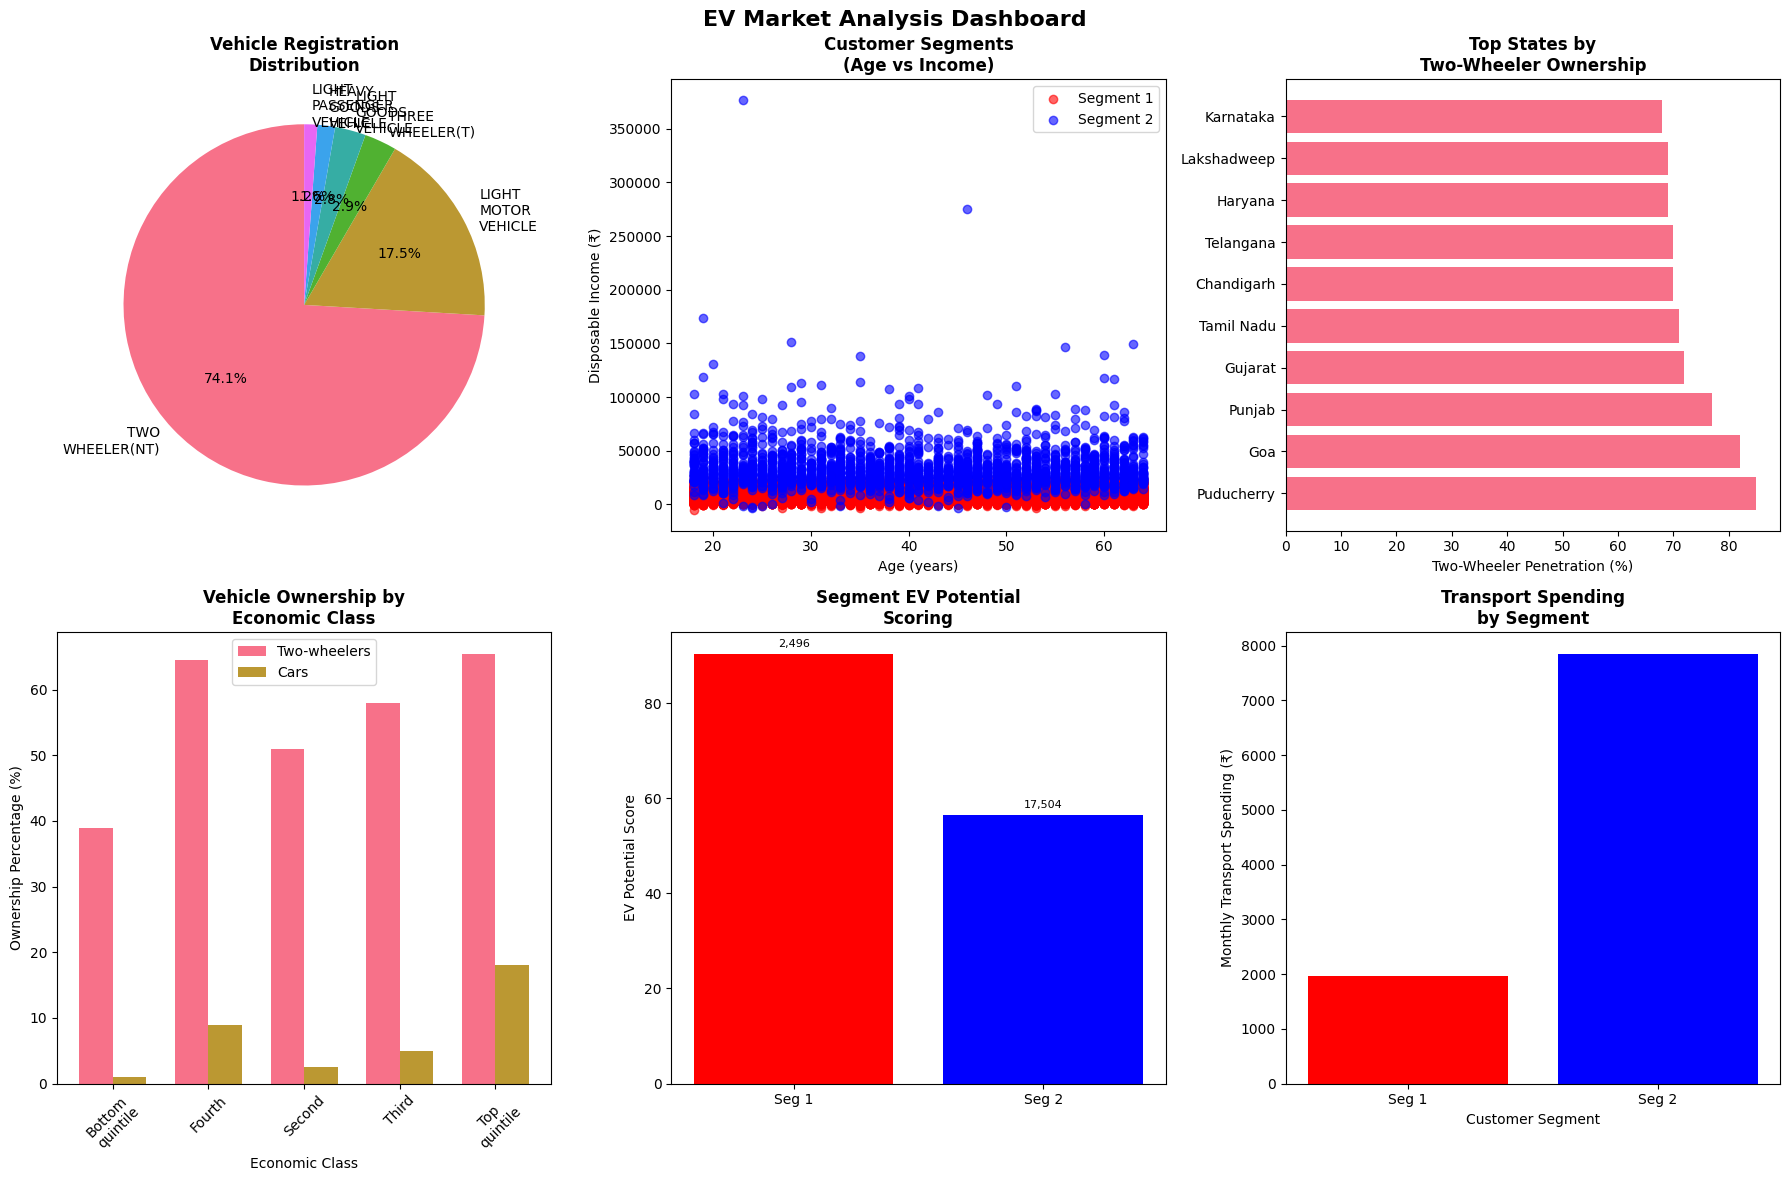


KEY TAKEAWAYS:
• Market Opportunity: Two-wheelers dominate with 73.3% market share
• Target Vehicle: Electric scooters for mass market appeal
• Primary Target: Young urban professionals (25-35 years) in Tier-1 cities
• Secondary Target: Middle-income families in Tier-2 cities
• Geographic Focus: Start with top metro cities, expand to tier-2
• Market Size: Primary segment represents 2,496 potential customers



In [8]:
#VISUALIZATION

print("\n6. KEY VISUALIZATIONS")
print("-" * 25)

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('EV Market Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Vehicle Registration Distribution
vehicle_class_top = vehicle_class_sorted.head(6)
axes[0,0].pie(vehicle_class_top['Total Registration'],
              labels=[label.replace(' ', '\n') for label in vehicle_class_top['Vehicle Class']],
              autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Vehicle Registration\nDistribution', fontweight='bold')

# 2. Customer Segments by Age and Income
scatter_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown'][:best_k]
for i in range(best_k):
    cluster_data = df_segment[df_segment['Cluster'] == i]
    axes[0,1].scatter(cluster_data['Age'], cluster_data['Disposable_Income'],
                     c=scatter_colors[i], label=f'Segment {i+1}', alpha=0.6)
axes[0,1].set_xlabel('Age (years)')
axes[0,1].set_ylabel('Disposable Income (₹)')
axes[0,1].set_title('Customer Segments\n(Age vs Income)', fontweight='bold')
axes[0,1].legend()

# 3. State-wise Two-Wheeler Penetration
top_states = state_ownership_df.nlargest(10, 'Two_Wheeler_Penetration')
axes[0,2].barh(range(len(top_states)), top_states['Two_Wheeler_Penetration'])
axes[0,2].set_yticks(range(len(top_states)))
axes[0,2].set_yticklabels([state[:15] for state in top_states['State']])
axes[0,2].set_xlabel('Two-Wheeler Penetration (%)')
axes[0,2].set_title('Top States by\nTwo-Wheeler Ownership', fontweight='bold')

# 4. Economic Class Vehicle Ownership
econ_pivot = economic_ownership_df.groupby('MPCE Quintiles')[['Two-wheeler', 'Car']].mean()
x_pos = np.arange(len(econ_pivot.index))
width = 0.35
axes[1,0].bar(x_pos - width/2, econ_pivot['Two-wheeler'], width, label='Two-wheelers')
axes[1,0].bar(x_pos + width/2, econ_pivot['Car'], width, label='Cars')
axes[1,0].set_xlabel('Economic Class')
axes[1,0].set_ylabel('Ownership Percentage (%)')
axes[1,0].set_title('Vehicle Ownership by\nEconomic Class', fontweight='bold')
axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels([q.replace(' ', '\n') for q in econ_pivot.index], rotation=45)
axes[1,0].legend()

# 5. Segment Size and EV Potential
segments = [f'Seg {i+1}' for i in range(best_k)]
sizes = [ev_potential_scores[i][2] for i in range(best_k)]
scores = [ev_potential_scores[i][1] for i in range(best_k)]

bars = axes[1,1].bar(segments, scores, color=scatter_colors[:best_k])
axes[1,1].set_ylabel('EV Potential Score')
axes[1,1].set_title('Segment EV Potential\nScoring', fontweight='bold')

# Add size labels on bars
for bar, size in zip(bars, sizes):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{size:,}', ha='center', va='bottom', fontsize=8)

# 6. Transport Spending by Segment
segment_transport = df_segment.groupby('Cluster')['Transport'].mean()
axes[1,2].bar(range(best_k), segment_transport.values, color=scatter_colors[:best_k])
axes[1,2].set_xlabel('Customer Segment')
axes[1,2].set_ylabel('Monthly Transport Spending (₹)')
axes[1,2].set_title('Transport Spending\nby Segment', fontweight='bold')
axes[1,2].set_xticks(range(best_k))
axes[1,2].set_xticklabels([f'Seg {i+1}' for i in range(best_k)])

plt.tight_layout()
plt.show()


print(f"""
KEY TAKEAWAYS:
• Market Opportunity: Two-wheelers dominate with {two_wheeler_percentage:.1f}% market share
• Target Vehicle: Electric scooters for mass market appeal
• Primary Target: Young urban professionals (25-35 years) in Tier-1 cities
• Secondary Target: Middle-income families in Tier-2 cities
• Geographic Focus: Start with top metro cities, expand to tier-2
• Market Size: Primary segment represents {ev_potential_scores[0][2]:,} potential customers
""")